In [1]:
import os
import torch
import numpy as np
import rasterio
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomTiffDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        
        # Load TIFF files using rasterio
        with rasterio.open(os.path.join(self.image_dir, img_name)) as src_image:
            image = src_image.read().astype(np.float32)
        
        # Construct the corresponding label filename
        label_name = img_name.replace('image_patch_', 'label_patch_')
        
        with rasterio.open(os.path.join(self.label_dir, label_name)) as src_label:
            label = src_label.read(1).astype(np.float32)  # Read as single channel
        
        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32)  # Shape: [C, H, W]
        
        # Ensure label values are within the valid range
        label = torch.tensor(label, dtype=torch.float32)  # Shape: [H, W]
        
        # Add a channel dimension to the label
        label = label.unsqueeze(0)  # Shape: [1, H, W]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Example of how to use the CustomTiffDataset class
image_dir = '/home/yshao/bog/newtrain/images'
label_dir = '/home/yshao/bog/newtrain/labels'

# Define transforms including normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.0),  # Scale the input values to [0, 1]
    transforms.Normalize(mean=mean, std=std)  # Normalize the tensors
])

dataset = CustomTiffDataset(image_dir, label_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Example usage
for images, labels in dataloader:
    print(images.shape)  # Should be [batch_size, C, H, W]
    print(labels.shape)  # Should be [batch_size, 1, H, W]
    break


torch.Size([4, 3, 256, 256])
torch.Size([4, 1, 256, 256])


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        self.bottleneck = self.conv_block(512, 1024)
        
        self.decoder4 = self.conv_block(1024 + 512, 512)
        self.decoder3 = self.conv_block(512 + 256, 256)
        self.decoder2 = self.conv_block(256 + 128, 128)
        self.decoder1 = self.conv_block(128 + 64, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))
        
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        
        dec4 = self.decoder4(torch.cat([F.interpolate(bottleneck, scale_factor=2, mode='bilinear', align_corners=True), enc4], dim=1))
        dec3 = self.decoder3(torch.cat([F.interpolate(dec4, scale_factor=2, mode='bilinear', align_corners=True), enc3], dim=1))
        dec2 = self.decoder2(torch.cat([F.interpolate(dec3, scale_factor=2, mode='bilinear', align_corners=True), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([F.interpolate(dec2, scale_factor=2, mode='bilinear', align_corners=True), enc1], dim=1))
        
        return self.final_conv(dec1)

In [3]:
import torch
import torch.optim as optim

# Define the device to use (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to the appropriate device
model = UNet(in_channels=3, out_channels=1).to(device)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

Epoch [1/30], Loss: 0.3138
Epoch [2/30], Loss: 0.2308
Epoch [3/30], Loss: 0.1897
Epoch [4/30], Loss: 0.1611
Epoch [5/30], Loss: 0.1446
Epoch [6/30], Loss: 0.1309
Epoch [7/30], Loss: 0.1134
Epoch [8/30], Loss: 0.1359
Epoch [9/30], Loss: 0.1127
Epoch [10/30], Loss: 0.0929
Epoch [11/30], Loss: 0.1107
Epoch [12/30], Loss: 0.1003
Epoch [13/30], Loss: 0.0943
Epoch [14/30], Loss: 0.0918
Epoch [15/30], Loss: 0.0898
Epoch [16/30], Loss: 0.1199
Epoch [17/30], Loss: 0.1016
Epoch [18/30], Loss: 0.0909
Epoch [19/30], Loss: 0.0888
Epoch [20/30], Loss: 0.0833
Epoch [21/30], Loss: 0.0833
Epoch [22/30], Loss: 0.0841
Epoch [23/30], Loss: 0.0902
Epoch [24/30], Loss: 0.0908
Epoch [25/30], Loss: 0.0812
Epoch [26/30], Loss: 0.0799
Epoch [27/30], Loss: 0.0774
Epoch [28/30], Loss: 0.0768
Epoch [29/30], Loss: 0.0782
Epoch [30/30], Loss: 0.0937


In [5]:
checkpoint_dir = '/home/yshao/bog'
checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth')
torch.save(model.state_dict(), checkpoint_path)
print(f'Model saved to {checkpoint_path}')

Model saved to /home/yshao/bog/model_epoch_30.pth


In [11]:
import torch
import torch.optim as optim
import os

# Define the device to use (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to the appropriate device
model = UNet(in_channels=3, out_channels=1).to(device)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Directory to save the model checkpoints
checkpoint_dir = '/home/yshao/bog'
os.makedirs(checkpoint_dir, exist_ok=True)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    # Save the model checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth')
    torch.save(model.state_dict(), checkpoint_path)
    print(f'Model saved to {checkpoint_path}')


Epoch [1/30], Loss: 0.3677
Model saved to /home/yshao/bog/model_epoch_1.pth
Epoch [2/30], Loss: 0.2845
Model saved to /home/yshao/bog/model_epoch_2.pth
Epoch [3/30], Loss: 0.2394
Model saved to /home/yshao/bog/model_epoch_3.pth
Epoch [4/30], Loss: 0.2257
Model saved to /home/yshao/bog/model_epoch_4.pth
Epoch [5/30], Loss: 0.2889
Model saved to /home/yshao/bog/model_epoch_5.pth
Epoch [6/30], Loss: 0.2488
Model saved to /home/yshao/bog/model_epoch_6.pth
Epoch [7/30], Loss: 0.2042
Model saved to /home/yshao/bog/model_epoch_7.pth
Epoch [8/30], Loss: 0.1849
Model saved to /home/yshao/bog/model_epoch_8.pth
Epoch [9/30], Loss: 0.1702
Model saved to /home/yshao/bog/model_epoch_9.pth
Epoch [10/30], Loss: 0.1807
Model saved to /home/yshao/bog/model_epoch_10.pth
Epoch [11/30], Loss: 0.1864
Model saved to /home/yshao/bog/model_epoch_11.pth
Epoch [12/30], Loss: 0.1714
Model saved to /home/yshao/bog/model_epoch_12.pth
Epoch [13/30], Loss: 0.1790
Model saved to /home/yshao/bog/model_epoch_13.pth
Epoc

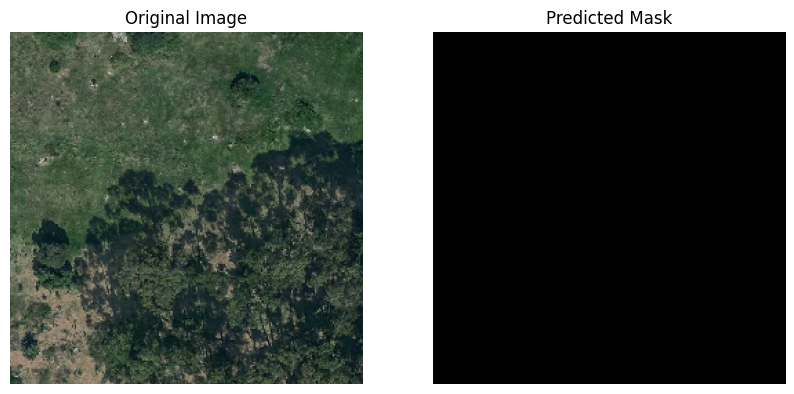

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
import rasterio
from rasterio.transform import from_origin

def load_image(image_path, transform=None):
    with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32)
    image = torch.tensor(image, dtype=torch.float32)  # Convert to tensor
    if transform:
        image = transform(image)
    return image

def predict_and_display(image_path, model, device, transform=None):
    # Load and preprocess the image
    model.eval()
    with torch.no_grad():
        image = load_image(image_path, transform).unsqueeze(0).to(device)
        
        # Make prediction
        output = model(image)
        pred_mask = torch.sigmoid(output).cpu().numpy().squeeze()
        
        # Threshold the predicted mask
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
        
        # Load the original image for display
        with rasterio.open(image_path) as src:
            original_image = src.read().transpose(1, 2, 0).astype(np.float32)  # Transpose to [H, W, C] for display
        
        # Display the original image and predicted mask
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(original_image / 255.0)  # Scale the image for display
        ax[0].set_title('Original Image')
        ax[0].axis('off')
        
        ax[1].imshow(pred_mask, cmap='gray')
        ax[1].set_title('Predicted Mask')
        ax[1].axis('off')
        
        plt.show()

# Example usage
image_path = '/home/yshao/bog/newtrain/images/image_patch_99.tif'

# Define the same transform used for training
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.0),  # Scale the input values to [0, 1]
    transforms.Normalize(mean=mean, std=std)  # Normalize the tensors
])

# Assuming model and device are already defined and model is loaded with weights
predict_and_display(image_path, model, device, transform=transform)


In [6]:
import os
import numpy as np
import torch
from torchvision import transforms
import rasterio

def load_image(image_path, transform=None):
    with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32)
    image = torch.tensor(image, dtype=torch.float32)  # Convert to tensor
    if transform:
        image = transform(image)
    return image

def predict_and_save(image_path, model, device, transform=None, output_dir=None):
    # Load and preprocess the image
    model.eval()
    with torch.no_grad():
        image = load_image(image_path, transform).unsqueeze(0).to(device)
        
        # Make prediction
        output = model(image)
        pred_mask = torch.sigmoid(output).cpu().numpy().squeeze()
        
        # Threshold the predicted mask
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
        
        # Load the original image metadata for saving
        with rasterio.open(image_path) as src:
            meta = src.meta.copy()
            transform = src.transform
            crs = src.crs
        
        # Update metadata to ensure compatibility with uint8
        meta.update({
            'count': 1,
            'dtype': 'uint8',
            'height': pred_mask.shape[0],
            'width': pred_mask.shape[1],
            'transform': transform,
            'crs': crs
        })
        
        # Remove nodata value if it's outside the uint8 range
        if 'nodata' in meta and (meta['nodata'] < 0 or meta['nodata'] > 255):
            del meta['nodata']
        
        # Save the predicted mask as a TIFF file
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, os.path.basename(image_path).replace('image_', 'predicted_'))
            with rasterio.open(output_path, 'w', **meta) as dst:
                dst.write(pred_mask, 1)
            print(f'Saved predicted mask to {output_path}')

# Function to process all TIFF files in a directory
def process_folder(input_dir, model, device, transform=None, output_dir=None):
    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            image_path = os.path.join(input_dir, filename)
            predict_and_save(image_path, model, device, transform, output_dir)

# Example usage
input_dir = '/home/yshao/bog/newtrain/images'
output_dir = '/home/yshao/bog/predictions'  # Directory to save the predicted masks

# Define the same transform used for training
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.0),  # Scale the input values to [0, 1]
    transforms.Normalize(mean=mean, std=std)  # Normalize the tensors
])

# Assuming model and device are already defined and model is loaded with weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load('/home/yshao/bog/model_epoch_30.pth'))

# Process all TIFF files in the input directory
process_folder(input_dir, model, device, transform=transform, output_dir=output_dir)


Saved predicted mask to /home/yshao/bog/predictions/predicted_patch_178.tif
Saved predicted mask to /home/yshao/bog/predictions/predicted_patch_309.tif
Saved predicted mask to /home/yshao/bog/predictions/predicted_patch_431.tif
Saved predicted mask to /home/yshao/bog/predictions/predicted_patch_190.tif
Saved predicted mask to /home/yshao/bog/predictions/predicted_patch_498.tif
Saved predicted mask to /home/yshao/bog/predictions/predicted_patch_491.tif
Saved predicted mask to /home/yshao/bog/predictions/predicted_patch_458.tif
Saved predicted mask to /home/yshao/bog/predictions/predicted_patch_593.tif
Saved predicted mask to /home/yshao/bog/predictions/predicted_patch_405.tif
Saved predicted mask to /home/yshao/bog/predictions/predicted_patch_396.tif
Saved predicted mask to /home/yshao/bog/predictions/predicted_patch_557.tif
Saved predicted mask to /home/yshao/bog/predictions/predicted_patch_200.tif
Saved predicted mask to /home/yshao/bog/predictions/predicted_patch_157.tif
Saved predic